# Imports

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import conexion_db
import seaborn as sns

# 1. Usuarios que más cláusulas HAN HECHO (robado)

C:\Users\juan_\AppData\Local\Temp\ipykernel_21372\1669652385.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_realizadas = pd.read_sql(query_realizadas, conn)


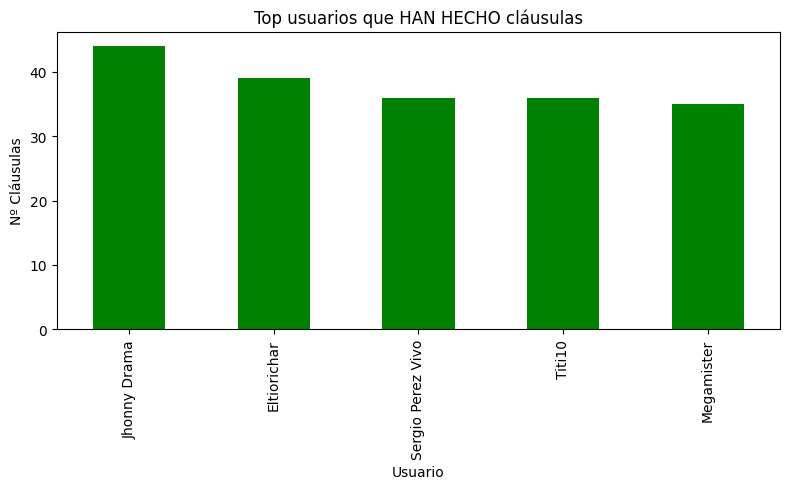

In [25]:
with conexion_db() as conn:
    query_realizadas = """
        SELECT usuario_destino AS usuario, COUNT(*) AS clausulas_realizadas
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cláusula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY usuario_destino
        ORDER BY clausulas_realizadas DESC
        LIMIT 5;
    """
    df_realizadas = pd.read_sql(query_realizadas, conn)

fig, ax = plt.subplots(figsize=(8, 5))
df_realizadas.plot(kind='bar', x='usuario', y='clausulas_realizadas', legend=False, ax=ax, color='green')
ax.set_title('Top usuarios que HAN HECHO cláusulas')
ax.set_xlabel('Usuario')
ax.set_ylabel('Nº Cláusulas')
plt.tight_layout()
plt.show()

 # 2. Usuarios que más cláusulas HAN SUFRIDO

C:\Users\juan_\AppData\Local\Temp\ipykernel_21372\2937050547.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sufridas = pd.read_sql(query_sufridas, conn)


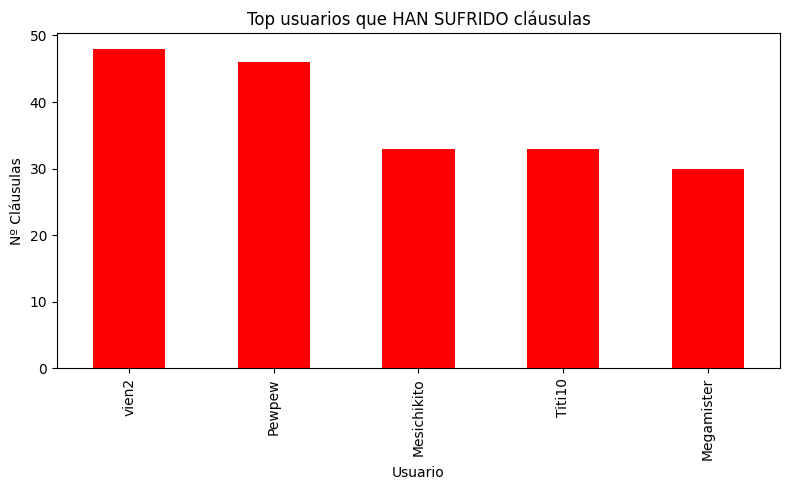

In [26]:
with conexion_db() as conn:
    query_sufridas = """
        SELECT usuario_origen AS usuario, COUNT(*) AS clausulas_sufridas
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cláusula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY usuario_origen
        ORDER BY clausulas_sufridas DESC
        LIMIT 5;
    """
    df_sufridas = pd.read_sql(query_sufridas, conn)

fig, ax = plt.subplots(figsize=(8, 5))
df_sufridas.plot(kind='bar', x='usuario', y='clausulas_sufridas', legend=False, ax=ax, color='red')
ax.set_title('Top usuarios que HAN SUFRIDO cláusulas')
ax.set_xlabel('Usuario')
ax.set_ylabel('Nº Cláusulas')
plt.tight_layout()
plt.show()

# Tops robos entre usuarios

C:\Users\juan_\AppData\Local\Temp\ipykernel_21372\1600032388.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_robos = pd.read_sql(query_robos, conn)


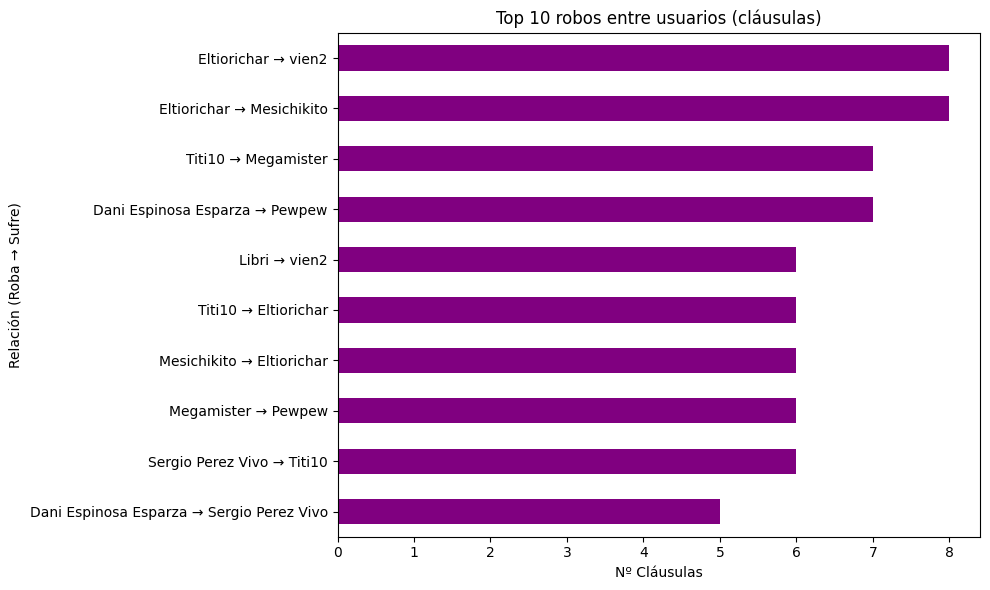

In [28]:
with conexion_db() as conn:
    query_robos = """
        SELECT 
            usuario_destino AS quien_roba,
            usuario_origen AS quien_sufre,
            COUNT(*) AS clausulas
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cláusula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY usuario_destino, usuario_origen
        ORDER BY clausulas DESC
        LIMIT 10;
    """
    df_robos = pd.read_sql(query_robos, conn)

# Crear una nueva columna para mostrar la relación
df_robos['relacion'] = df_robos['quien_roba'] + ' → ' + df_robos['quien_sufre']

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
df_robos.plot(kind='barh', x='relacion', y='clausulas', ax=ax, color='purple', legend=False)
ax.set_title('Top 10 robos entre usuarios (cláusulas)')
ax.set_xlabel('Nº Cláusulas')
ax.set_ylabel('Relación (Roba → Sufre)')
plt.gca().invert_yaxis()  # Para que el más alto aparezca arriba
plt.tight_layout()
plt.show()


# HeatMap Robos entre usuarios

C:\Users\juan_\AppData\Local\Temp\ipykernel_21372\2185274892.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(query, conn)


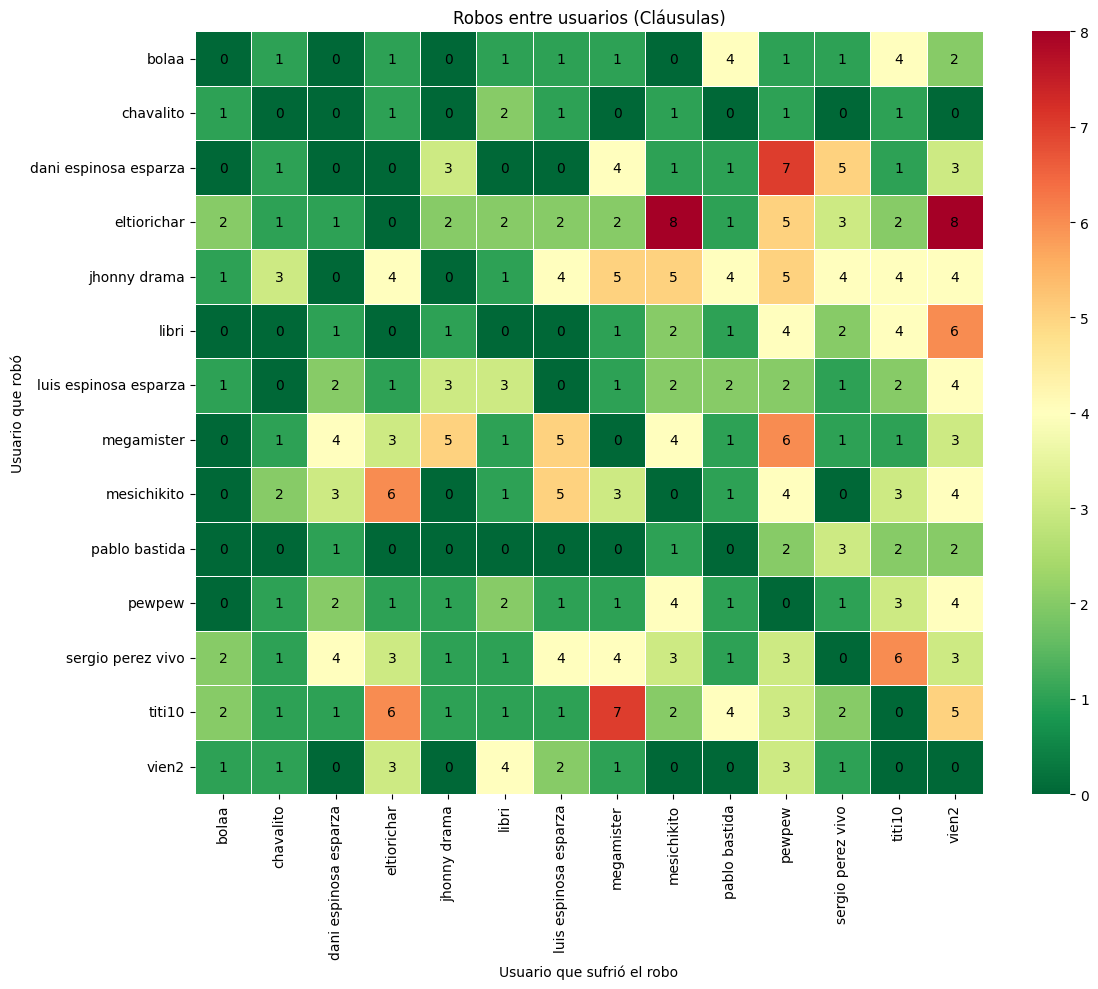

In [51]:
# 1. Cargar datos brutos
with conexion_db() as conn:
    query = """
        SELECT 
            usuario_destino AS quien_roba,
            usuario_origen AS quien_sufre,
            COUNT(*) AS clausulas
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cláusula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY usuario_destino, usuario_origen;
    """
    df_raw = pd.read_sql(query, conn)

# 2. Limpiar antes de agrupar
df_raw['quien_roba'] = df_raw['quien_roba'].str.strip().str.lower()
df_raw['quien_sufre'] = df_raw['quien_sufre'].str.strip().str.lower()

# 3. Re-agrupar (por si los nombres duplicados generaron filas separadas)
df = df_raw.groupby(['quien_roba', 'quien_sufre'], as_index=False).sum()

# 4. Crear la tabla pivote
pivot = df.pivot(index='quien_roba', columns='quien_sufre', values='clausulas').fillna(0)

# 5. Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".0f",
    cmap='RdYlGn_r',
    linewidths=0.5,
    cbar=True,
    annot_kws={"size": 10, "color": "black"}
)
plt.title("Robos entre usuarios (Cláusulas)")
plt.xlabel("Usuario que sufrió el robo")
plt.ylabel("Usuario que robó")
plt.tight_layout()
plt.show()


In [27]:
conn.close()